# Translating Plate at 60°

In [1]:
using PyPlot
using VortexModel

function plot_system(sys)
    plate, (sheet₊, sheet₋) = sys
    plot(real.(plate.zs[[1,N]]), imag.(plate.zs[[1,N]]), "k")
    plot(real.(getfield.(sheet₊.blobs, :z)), imag.(getfield.(sheet₊.blobs, :z)), linewidth = 1, color="#e41a1c")
    plot(real.(getfield.(sheet₋.blobs, :z)), imag.(getfield.(sheet₋.blobs, :z)), linewidth = 1, color="#377eb8")
    axis(:scaled)
end

plot_system (generic function with 1 method)

## Parameters

We are simulating a flat plate with zero thickness impulsively translating horizontally:

In [2]:
L = 2.0   # chord length
ċ = 0.5L  # translation velocity
α = π/3   # angle of attack

N = 128   # number of plate control points

Δt = 1e-2; # time step

We discretize the shear layers as vortex sheets, and assume that the Kutta condition is enforced at both edges of the plate.

In [3]:
δ = 0.2
lesp = tesp = 0.0

0.0

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [4]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
    
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Vortex.Plates.enforce_no_flow_through!(plate, motion, (sheet₊, sheet₋))
    
    Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, segment₊, segment₋, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

We apply Fourier filtering to the sheet to redistribute the sheet's control points and supress small scale instabilities.

In [5]:
function filter_sheet!(sheet, Δs, Δf)
    if length(sheet) < 5
        return
    end
    zs = Vortex.position.(sheet.blobs)
    zs, (Γs,) = Vortex.Sheets.filter_by_arclength(zs, Δs, Δf, sheet.Γs)
    Vortex.Sheets.remesh!(sheet, zs, Γs)
end

filter_sheet! (generic function with 1 method)

At every time-step, before computing the self induced velocity of the system, we must first enforce the no-flow-through condition on the plate.  So the velocity function for time marching is:

In [6]:
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = ẋ[1]
    
    Vortex.Plates.enforce_no_flow_through!(plate, motion, ambient_sys)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x)
end

compute_ẋ! (generic function with 1 method)

## Initialization

We place the initial segments of the vortex sheet perpendicular to the edges of the plate

In [7]:
plate = Vortex.Plate(N, L, zero(Complex128), α)
motion = Vortex.Plates.PlateMotion(ċ, 0.0)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, motion, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

ambient_sys = (sheet₊, sheet₋)
sys = (plate, ambient_sys)
ẋs = (motion, allocate_velocity(ambient_sys));

### Forward-Euler

We apply filtering on both the leading and trailing edge vortex sheets, and use the Kutta condition on both edges to determine the strength of new vortex segments:

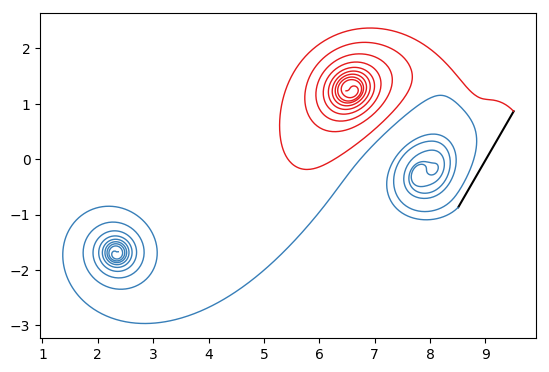

In [8]:
for t in 0.0:Δt:9.0
    forward_euler!(sys, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    filter_sheet!(sheet₊, 3Δt, 6Δt)
    filter_sheet!(sheet₋, 3Δt, 6Δt)
     
    shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp, tesp)
end

plot_system(sys);

### RK4

We rerun the simulation with the same parameters, except we use 4th-order Runge-Kutta instead of forward-Euler:

In [9]:
plate = Vortex.Plate(N, L, zero(Complex128), α)
motion = Vortex.Plates.PlateMotion(ċ, 0.0)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, motion, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

ambient_sys = (sheet₊, sheet₋)
sys₋ = (plate, ambient_sys)
sys₊ = deepcopy(sys₋)
ẋs = [(motion, allocate_velocity(ambient_sys)) for k in 1:4];

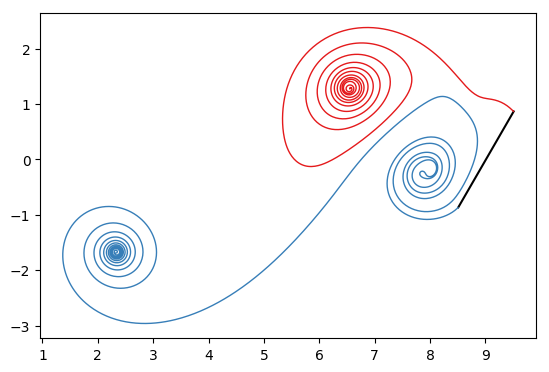

In [10]:
for t in 0.0:Δt:9.0
    rk4!(sys₊, sys₋, t, Δt, compute_ẋ!, advect!, ẋs)

    filter_sheet!(sys₊[2][1], 3Δt, 6Δt)
    filter_sheet!(sys₊[2][2], 3Δt, 6Δt)
     
    shed_new_vorticity!(sys₊[2][1], sys₊[2][2], sys₊[1], motion, lesp, tesp)
    sys₊, sys₋ = sys₋, sys₊
end

plot_system(sys₋);